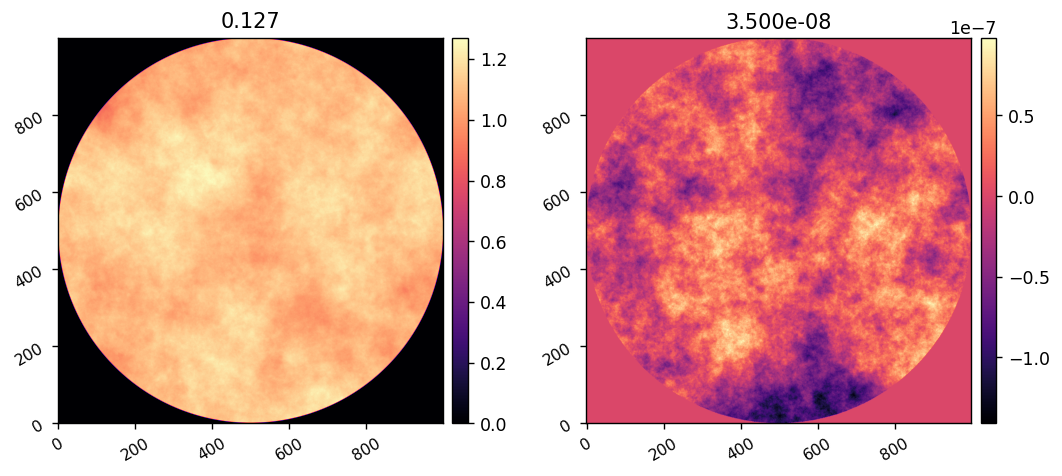

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob_oop as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = 650e-9/2/np.pi * xp.angle(WFE)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

# Establish the forward model parameters.

In [2]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

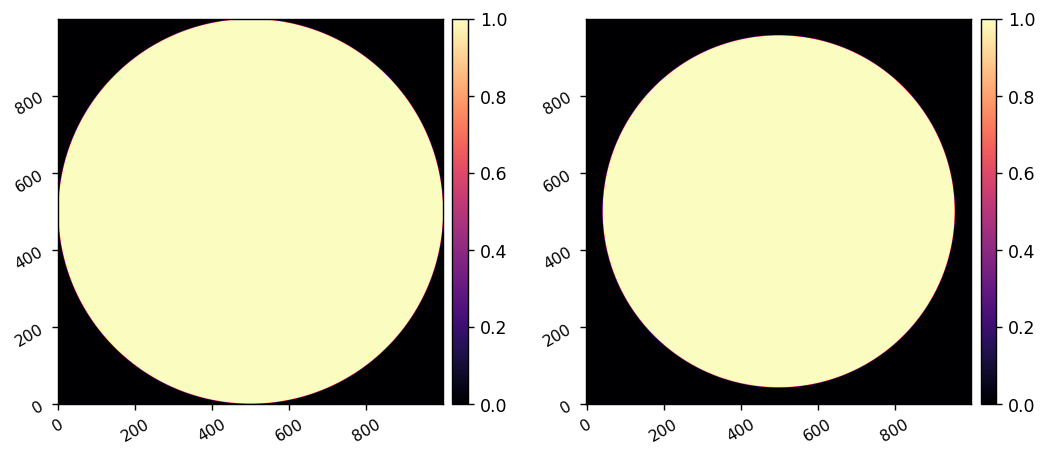

In [3]:
imshow2(m.APERTURE, m.LYOT, npix=m.npix)

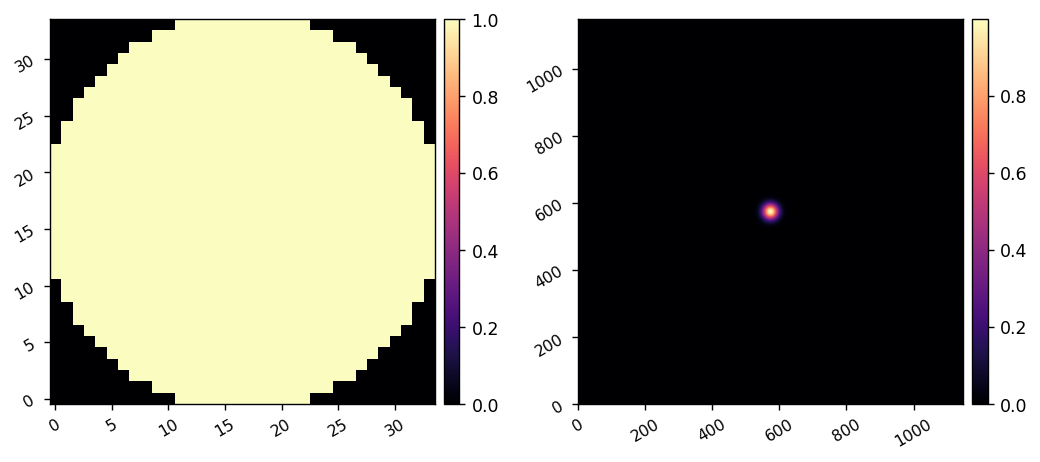

In [4]:
imshow2(m.dm_mask, m.inf_fun)

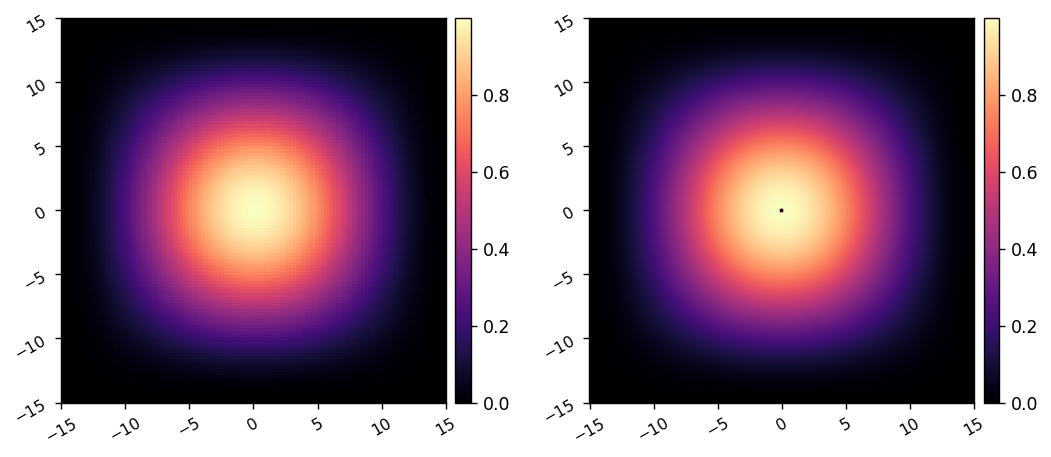

In [5]:
imshow2(m.lres_window, m.hres_window, npix1=m.lres_win_size,
        pxscl1=m.lres_sampling, pxscl2=m.hres_sampling)

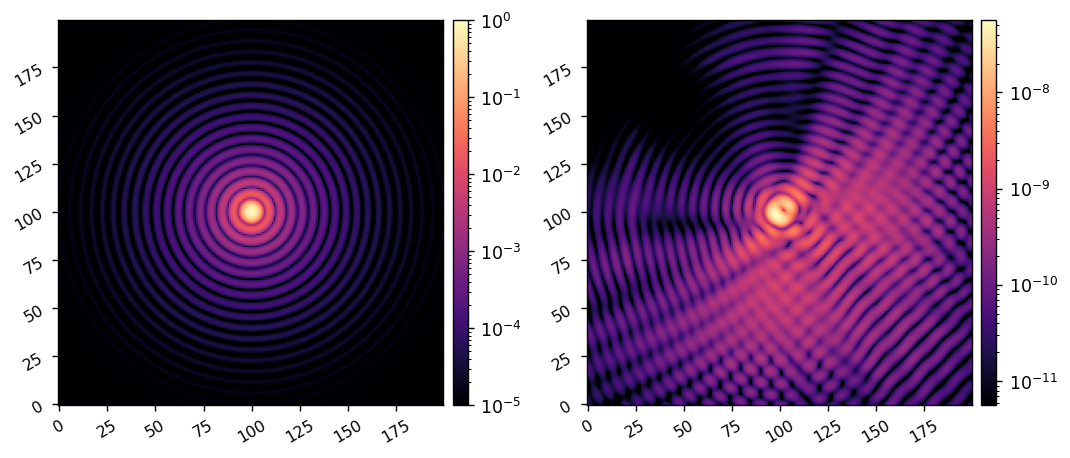

In [5]:
m.Imax_ref = 1
test_psf = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=False, use_wfe=False))**2
m.Imax_ref = xp.max(test_psf)
test_coro_im = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=True, use_wfe=False))**2
imshow2(test_psf/m.Imax_ref, test_coro_im, lognorm=True, vmin1=1e-5, vmin2=xp.max(test_coro_im)/1e4)

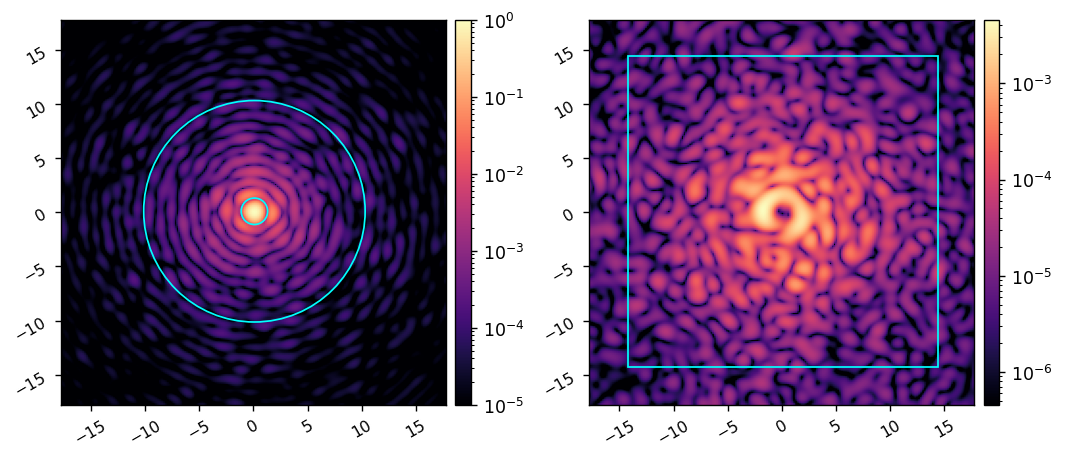

In [6]:
acts = np.zeros(m.Nacts)

# waffle_command = 10e-9 * xp.ones((m.Nact,m.Nact))
# waffle_command[1::2, ::2] *= -1
# waffle_command[::2, 1::2] *= -1
# acts = ensure_np_array(waffle_command[m.dm_mask]) 

m.Imax_ref = 1
ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow2(ref_psf/m.Imax_ref, ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)


# Test normal EFC

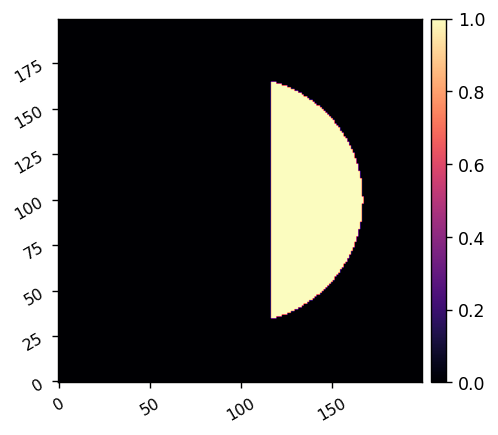

In [8]:
m.create_control_mask()
imshow1(m.control_mask)

In [13]:
reload(ad_scoob)

poke_modes = ad_scoob.create_poke_modes(m)

In [21]:
reload(ad_scoob)

jac = ad_scoob.compute_jacobian(m, poke_modes)


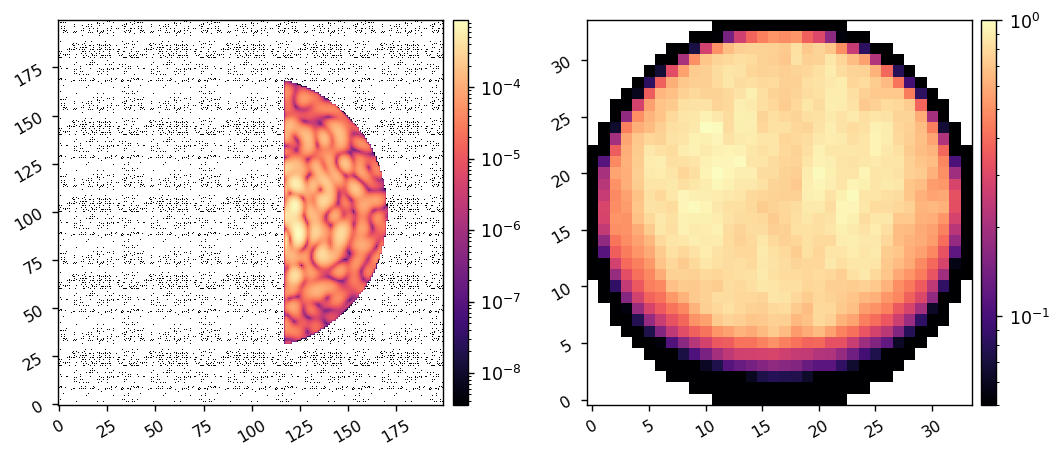

In [25]:
responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.sum(xp.square(xp.abs(responses.dot(poke_modes.reshape(m.Nacts, m.Nact**2)))), axis=0)).reshape(m.Nact,m.Nact)
dm_response /= dm_response.max()
imshow2(m.control_mask*ref_coro_im, dm_response, lognorm=True, vmin2=5e-2)

In [26]:
all_ims = []
all_efs = []
all_commands = []

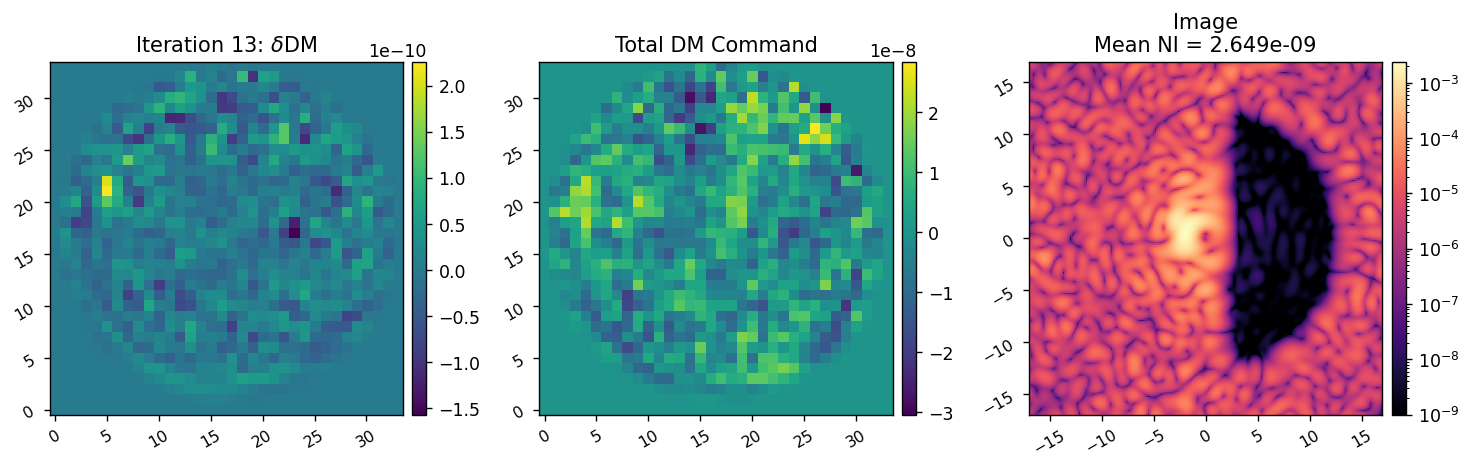

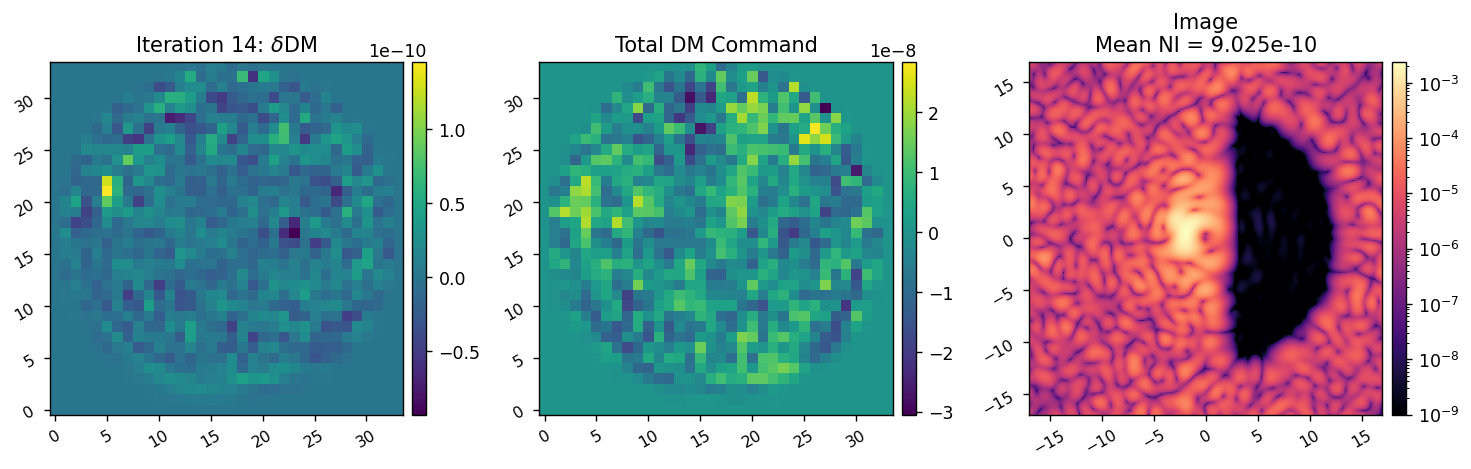

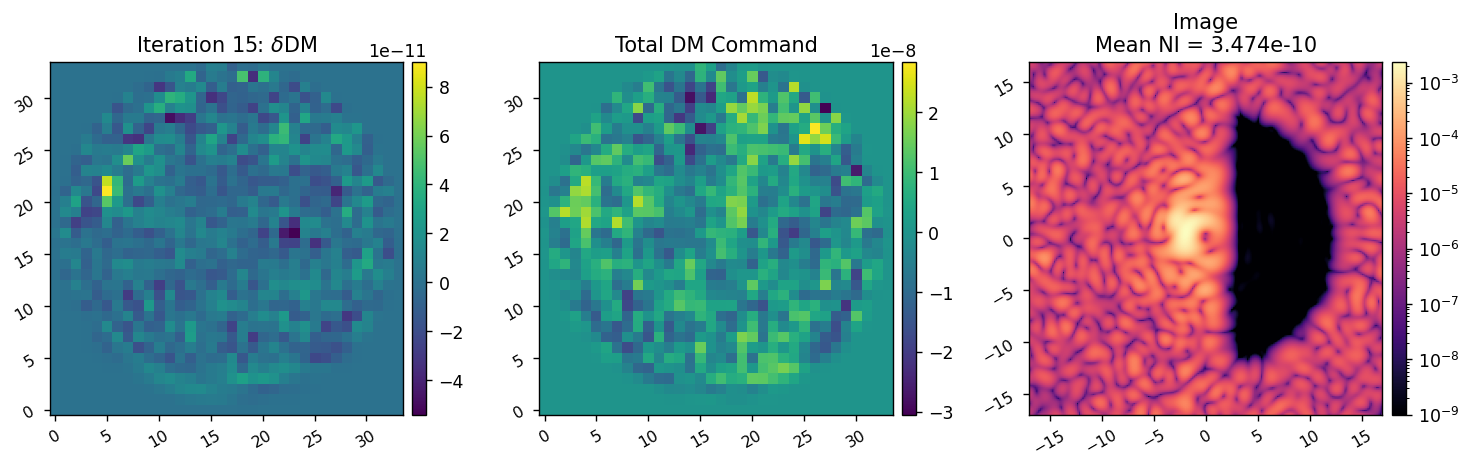

In [34]:
reload(ad_scoob)

cm = ad_scoob.beta_reg(jac, -2.5)
# cm = ad_scoob.beta_reg(jac, -4.5)

all_ims, all_efs, all_commands = ad_scoob.efc(m,
                                              cm, 
                                              Nitr=3, 
                                              nominal_command=all_commands[-1], 
                                              all_ims=all_ims, 
                                              all_efs=all_efs,
                                              all_commands=all_commands,
                                              )



# Test minimzation with L-BFGS-B

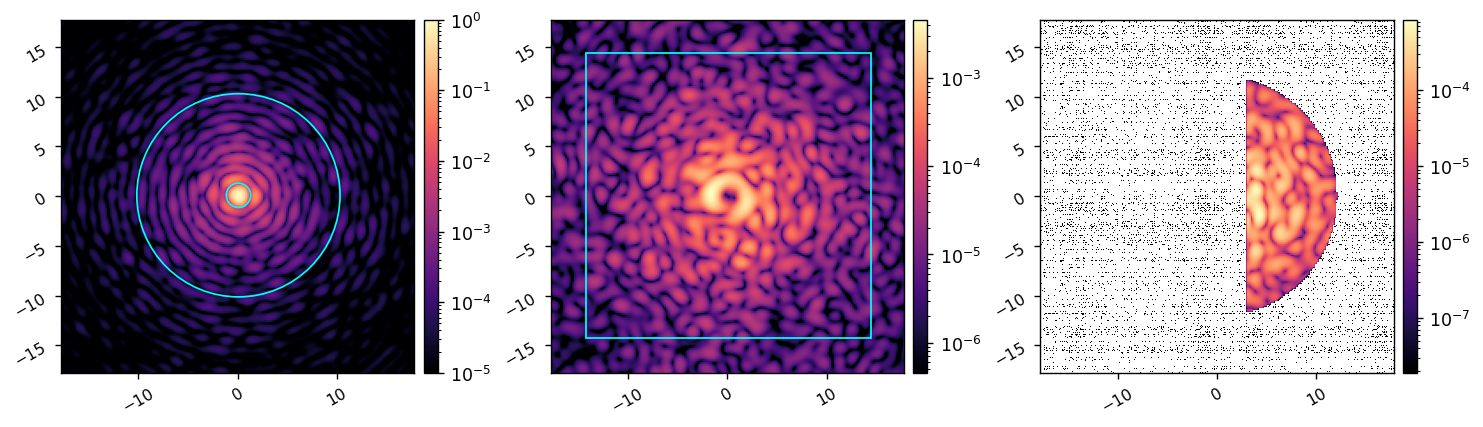

In [7]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE
m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow3(ref_psf/m.Imax_ref, ref_coro_im, m.control_mask*ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True,  vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

0.3261451405070691 0.0 0.3260577535750728 1.0002680105933326


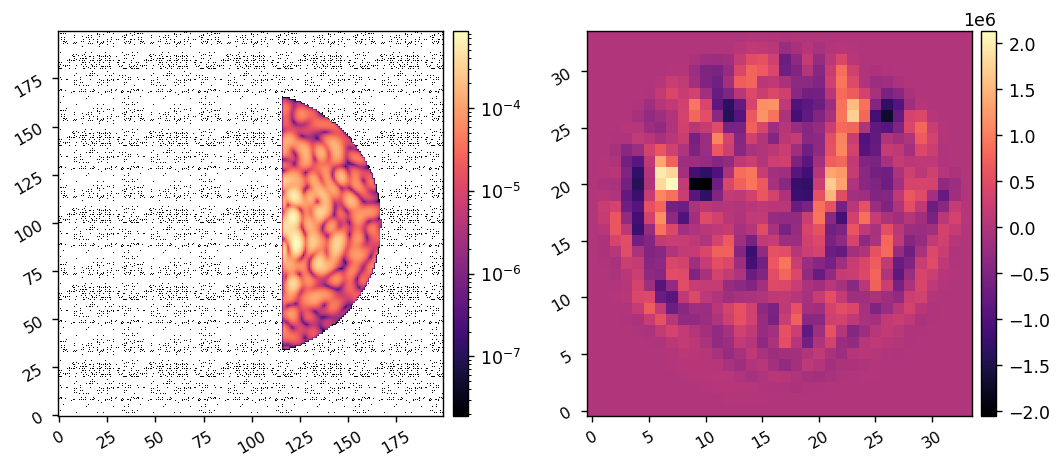

In [50]:
reload(ad_scoob)
del_acts = np.zeros(m.Nacts)
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2
E_target = 0
E_model_nom = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)

J, dJ_dA = ad_scoob.val_and_grad(del_acts, 
                                 m,
                                 E_ab,
                                 r_cond=r_cond,
                                 E_target=E_target, 
                                 verbose=True,
                                )

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(m.control_mask*ref_coro_im, dm_grad, lognorm1=True)

In [82]:
utils.save_fits('test_acts.fits', res.x)

Saved data to:  test_acts.fits


0.3260577535750728 0.0 0.3260577535750728 1.0


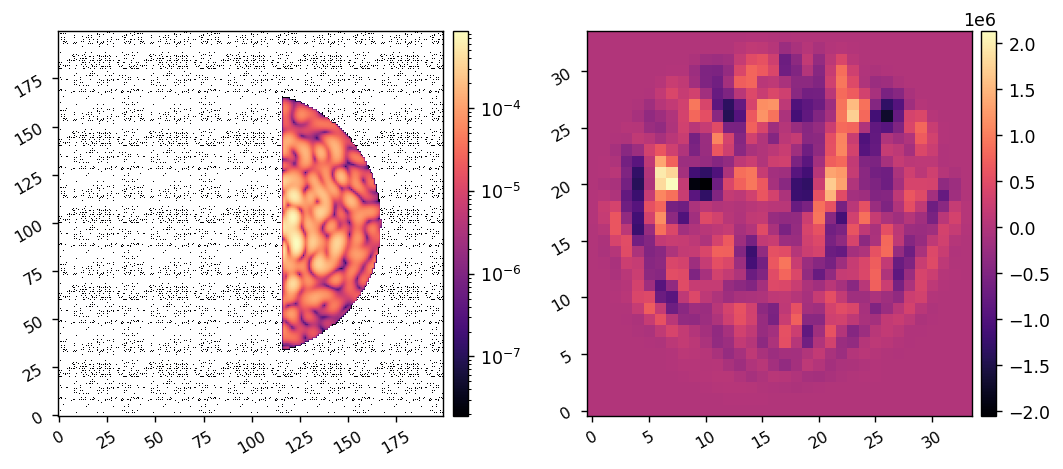

In [94]:
reload(ad_scoob)
del_acts = np.zeros(m.Nacts)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('test_acts.fits')
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2

J, dJ_dA = ad_scoob.val_and_grad(del_acts, 
                                 m,
                                 acts, 
                                 E_ab,
                                 r_cond,
                                 verbose=True,
                                )

current_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2
dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(m.control_mask*current_im, dm_grad, lognorm1=True)

# Does E_ep_k-1 contain the wavefront contribution from the total accumulated DM command?

In [95]:
reload(ad_scoob)

bfgs_tol = 1e-2
bfgs_opts = {
    # 'maxiter':20,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
    'disp':True, 
}

# del_acts0 = np.zeros(m.Nacts)
# acts = np.zeros(m.Nacts)
# E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
# r_cond = 5e-2
# E_target = 0
# E_model_nom = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=False) * m.control_mask)

# res = minimize(ad_scoob.val_and_grad, 
#                 jac=True, 
#                 x0=del_acts0,
#                 args=(m, E_ab, r_cond, E_target, E_model_nom, True), 
#                 method='L-BFGS-B',
#                 tol=bfgs_tol,
#                 options=bfgs_opts,
#                 )


del_acts0 = np.zeros(m.Nacts)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('test_acts.fits')
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 5e-2

res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

0.3260577535750728 0.0 0.3260577535750728 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.12966D+06
0.008300794427189943 5917159763.313609 0.3260577535750728 18147581826.970787
0.008939347201326747 166.78390050992 0.3260577535750728 511.5438538980129


 This problem is unconstrained.


0.06293533520189676 10.170450561451856 0.3260577535750728 31.385194139533255
0.5605600056267023 0.9612922356313227 0.3260577535750728 4.667431534970777
4.741109323308781 0.09147020425566305 0.3260577535750728 14.821237877576719
7.644461031300306 0.005629104718110804 0.3260577535750728 23.46237760684636
0.16234783716944806 0.0002029201636588024 0.3260577535750728 0.49853363568512893

At iterate    1    f=  4.98534D-01    |proj g|=  1.87959D+06
0.022035506335445734 0.00010194428212019066 0.3260577535750728 0.0678942622122584

At iterate    2    f=  6.78943D-02    |proj g|=  2.62637D+05
0.013219842138003637 0.00010752673749534476 0.3260577535750728 0.04087425840781436

At iterate    3    f=  4.08743D-02    |proj g|=  2.03371D+05
0.0061405645700714565 0.00013345332629835762 0.3260577535750728 0.019242044783717313

At iterate    4    f=  1.92420D-02    |proj g|=  1.13889D+05
0.003626792196681705 0.00014821528177521223 0.3260577535750728 0.011577726452034042

At iterate    5    f=  1.15777D-

6.667847721371633e-05 7.416752958449294e-07


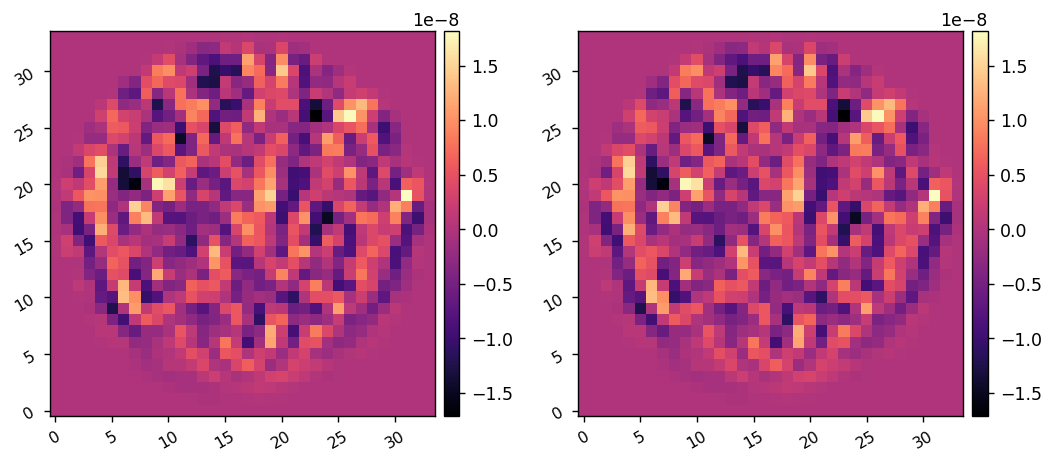

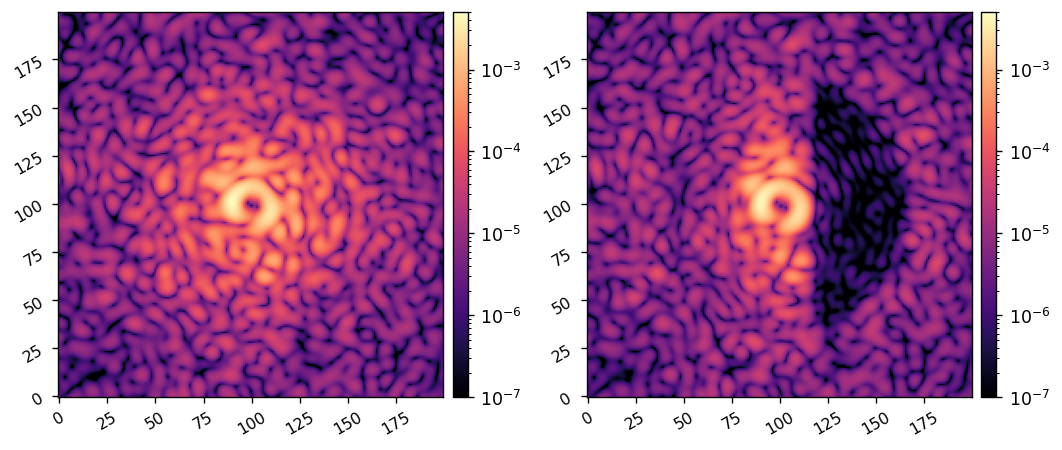

In [96]:
del_command = xp.zeros((m.Nact,m.Nact))
del_command[m.dm_mask] = res.x

total_command = xp.zeros((m.Nact,m.Nact))
total_command[m.dm_mask] = acts + res.x

prev_im = xp.abs(m.forward(acts, use_wfe=True))**2
new_im = xp.abs(m.forward(acts + res.x, use_wfe=True))**2

print(xp.mean(prev_im[m.control_mask]), xp.mean(new_im[m.control_mask]))
imshow2(del_command, total_command)
imshow2(prev_im, new_im, lognorm=True, vmin1=1e-7, vmin2=1e-7, vmax1=5e-3, vmax2=5e-3)

# Test a full EFC run with L-BFGS-B

In [86]:
reload(ad_efc)
reload(ad_scoob)


<module 'scoobpsf.ad_scoob_oop' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/ad_scoob_oop.py'>

In [120]:
all_ims = []
all_efs = []
all_commands = []

In [117]:
bfgs_tol = 1e-3
bfgs_opts = {
    # 'maxiter':20,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
    'disp':False, 
}

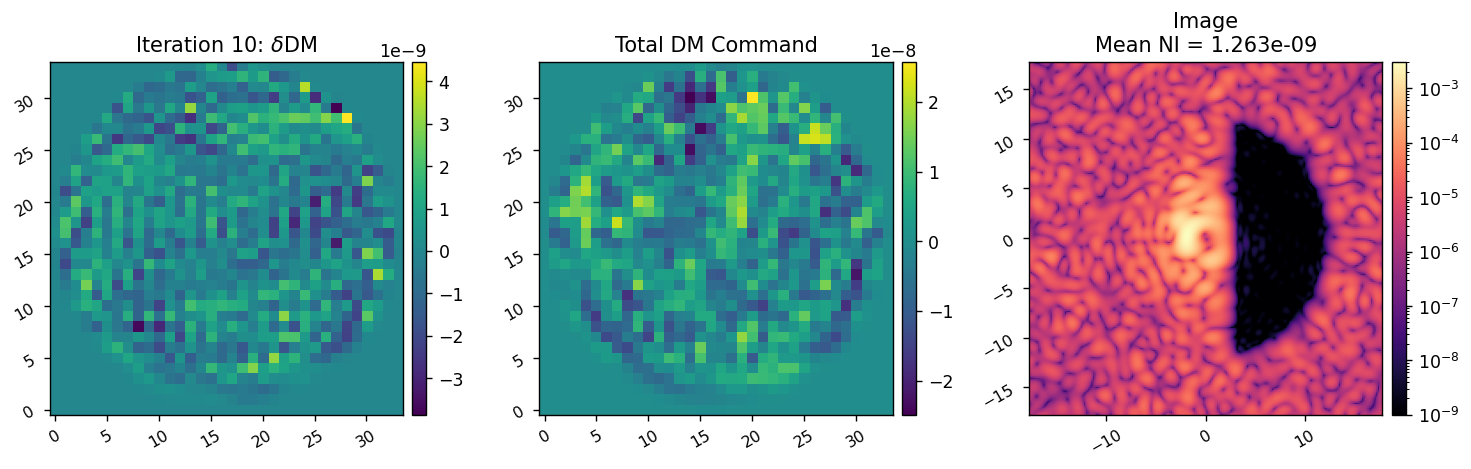

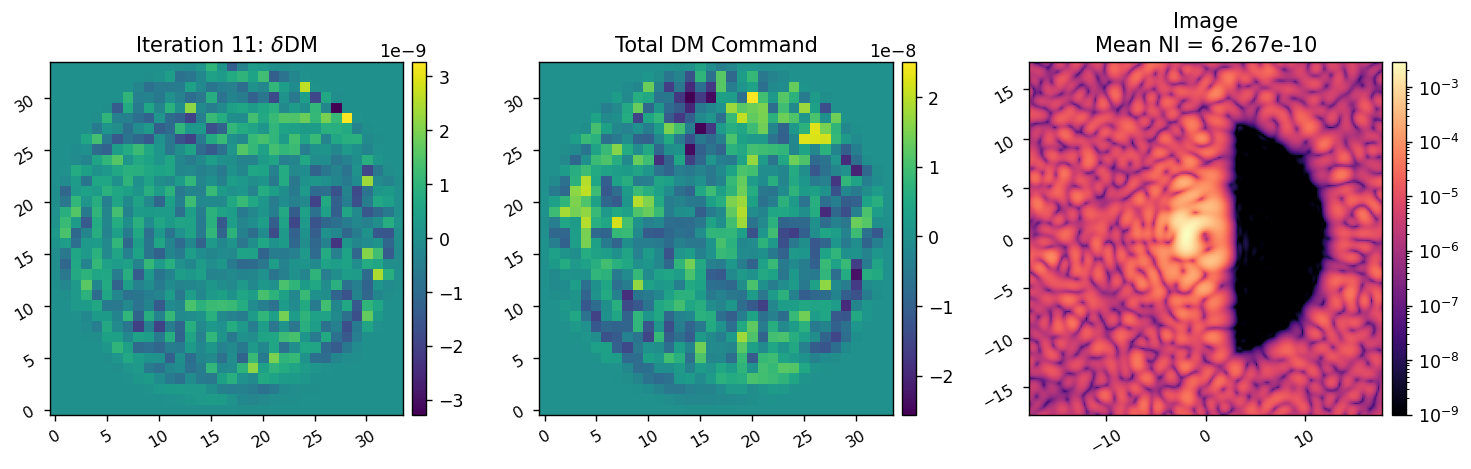

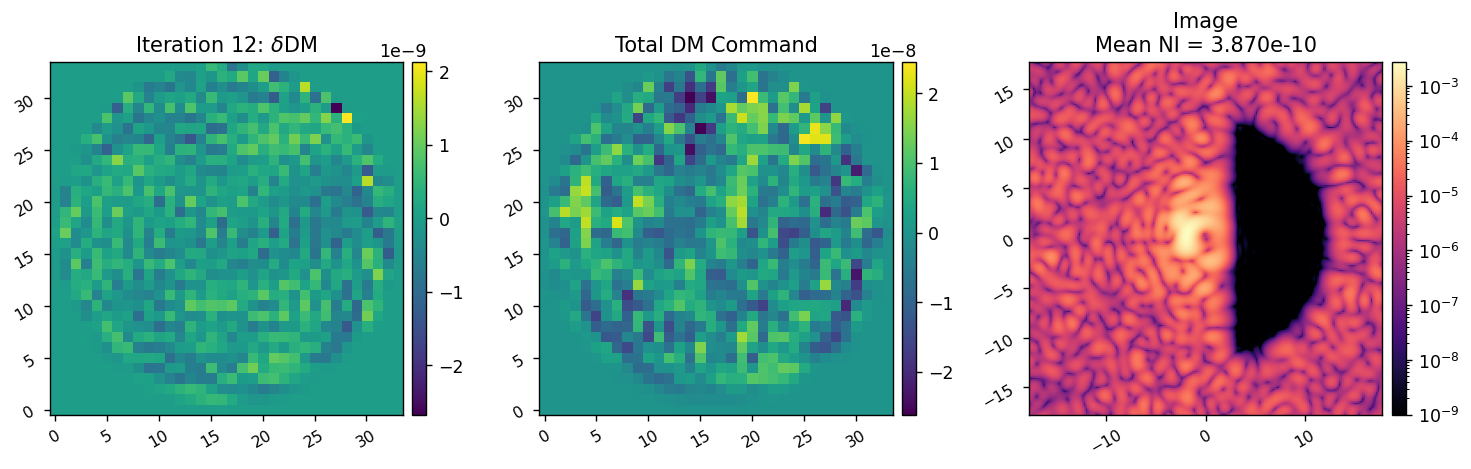

In [124]:
reload(ad_efc)
reload(ad_scoob)

# reg_cond = 1
reg_cond = 5e-2
# reg_cond = 5e-3
reg_cond = 5e-4
# reg_cond = 1e-3
# reg_cond = 1e-4

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=reg_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=0.5,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )